## Setting Up

In [34]:
from numpy import (
    pi,cos,arange,ones,tile,dot,eye,diag,exp,zeros,sinh,cosh,
    linspace,polyval,polyfit,inf,finfo,log2,power, array
    )

from numpy.linalg import norm
from scipy.linalg import solve

from matplotlib.style import use
use("seaborn")

from pltconfig import *

%matplotlib inline

In [19]:
def cheb(N):
    '''Chebushev polynomial differentiation matrix.
       Ref.: Trefethen's 'Spectral Methods in MATLAB' book.
    '''
    x = cos(pi*arange(0,N+1)/N)
    if (N%2 == 0):
        x[N//2] = 0.0 # only when N is even!
    c = ones(N+1); c[0] = 2.0; c[N] = 2.0
    c = c * (-1.0)**arange(0,N+1)
    c = c.reshape(N+1,1)
    X = tile(x.reshape(N+1,1), (1,N+1))
    dX = X - X.T
    D = dot(c, 1.0/c.T) / (dX+eye(N+1))
    D = D - diag( D.sum(axis=1) )
    return D,x

# Problem 1

## Part A

In [79]:
class q1a(object):
    
    def __init__(self, left=0.0, right=1.0, alpha=0.0, beta=0.0, epsilon=1.0, N=16, N_fine=200):
        
        # unload the variables
        self.left = left
        self.right = right
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.N = N
        self.N_fine = N_fine
        
        # find the transformation that rescales the domain [left, right] to [-1,1]
        self.b, self.m = solve(
            array([[1, self.left],
                   [1, self.right]]), 
            array([-1, 1])
            )
        
        # get the LHS matrix and the grid points
        self.A, self.z, self.x = self.get_A()
        
        # get the RHS vector 
        self.F = self.get_rhs()

        # get the exact solution
        self.u = self.get_exact_soln()
        
        # compute the solution
        self.U = self.compute_soln()
        
    def get_A(self):
        
        # compute the Chebyshev differentiation matrices
        D, z = cheb(self.N)
        
        # rescale diff. matrix according to transformation
        D *= self.m
        
        # compute original grid [left, right] from TChebyshev grid
        x = (1./self.m)*(z - self.b)
        
        # impose the boundary conditions on LHS
        A = (self.epsilon*dot(D,D) + D)
        
        # LHS boundary
        A[0,:] = zeros(self.N+1)
        A[0,0] = 1.0
        
        # RHS boundary
        A[-1,:] = zeros(self.N+1)
        A[-1,-1] = 1.0
        
        return A, z, x
        
    def get_rhs(self):
        
        F = -exp(1-self.x)
        
        # set boundary conditions on the RHS
        F[0] = self.alpha
        F[-1] = self.beta
        
        # get the RHS
        return F
        
    def compute_soln(self):   
        return solve(self.A,self.F)
    
    def get_exact_soln(self, xx=None):
        
        if xx is not None:
            x = xx
        else:
            x = self.x
        
        if (abs(self.epsilon-1.0) < finfo('float32').eps):
            cofactor = exp(1-x)/(exp(1)-1)
            return -cofactor*(exp(x)-exp(1)*x+x-1)
        else:
            cofactor = exp(-x)/((self.epsilon-1)*(power(exp(1),1/self.epsilon)-1))
            return cofactor*(
                exp((1/self.epsilon)+x)
                - exp(((self.epsilon-1)*x+1)/self.epsilon) 
                + exp((((self.epsilon-1)*x)/self.epsilon)+(1./self.epsilon)+1)
                - exp((1/self.epsilon)+1)
                - exp(x+1)
                + exp(1)
            )
        
    def get_soln_plot(self, save=False):
        
        # compute the error in the solution from the exact
        maxerr = norm(self.U-self.u,inf)
        
        # define the finer grid
        xx = linspace(self.left, self.right, self.N_fine+1)        
        
        fig, ax = subplots(1,1,figsize=(10,10))

        ax.plot(xx, self.get_exact_soln(xx), "r-", lw=3.0, label="Exact soln")
        ax.plot(self.x, self.U, "ko", lw=3.0, label="Computed soln")
        
        ax.legend(loc=0, prop={"size": 18})
        ax.tick_params(labelsize=18)
        ax.set_ylabel(r"$U(x)$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        ax.set_title(f"Computed solution, maxerr: {maxerr:.4e}",fontsize=28)
        
        fig.tight_layout()
        
        if save: fig.savefig("q1a_soln_figure.pdf")

In [80]:
sample_q1a = q1a(N=24)

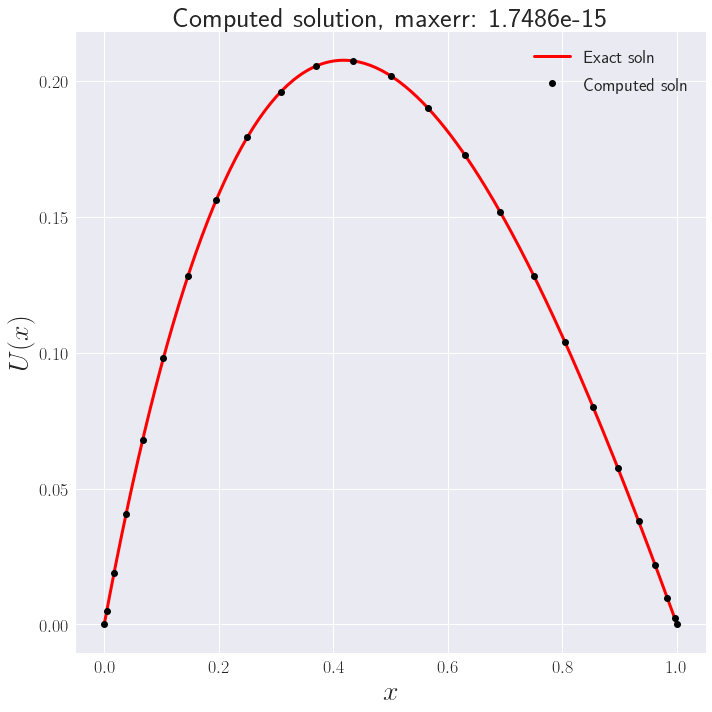

In [81]:
sample_q1a.get_soln_plot(save=True)

In [82]:
def q1a_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        Nvals = zeros(n)
        pt_error_array_norm = zeros(n)
        error_array_infnorm = zeros(n)
        error_array_infnorm_epsilon = zeros(n)

        # set the number of initial number of internal points
        N_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q1a(N=N_coarse)
        soln_coarse_epsilon = q1a(N=N_coarse, epsilon=0.01)

        print(f"N    err (eps=1)    order (eps=1)    err (eps=0.01)    order (eps=0.01)")
        
        for i in range(n):

            # define the finer grids
            N_fine = 2*N_coarse

            # construct the meshes and solve 
            soln_fine = q1a(N=N_fine)
            
            # non-unitary epsilon
            soln_fine_epsilon = q1a(N=N_fine, epsilon=0.01)

            # compute the errors using the infinity-norm
            error_array_infnorm[i] = norm((soln_coarse.U-soln_fine.U[::2]).flatten(), ord=inf)
            error_array_infnorm_epsilon[i] = norm(
                (soln_coarse_epsilon.U-soln_fine_epsilon.U[::2]).flatten(), ord=inf
                )

            # record the number of points
            Nvals[i] = N_coarse
            
            if (i > 0):
                print(
                    f"{N_coarse:<5d}"
                    + f"{error_array_infnorm[i]:<15.2e}"
                    + f"{-log2((error_array_infnorm[i]/error_array_infnorm[i-1]).__abs__()):<17.5f}"
                    + f"{error_array_infnorm_epsilon[i]:<18.2e}"
                    + f"{-log2((error_array_infnorm_epsilon[i]/error_array_infnorm_epsilon[i-1]).__abs__()):<16.5f}"
                    )
            else:
                print(
                    f"{N_coarse:<5d}"
                    + f"{error_array_infnorm[i]:<32.2e}"
                    + f"{error_array_infnorm_epsilon[i]:<18.2e}"
                    )
                
            # set the current fine grid as the coarse grid for next iteration
            N_coarse = N_fine 
            soln_coarse = soln_fine
            soln_coarse_epsilon = soln_fine_epsilon

        return Nvals, error_array_infnorm, error_array_infnorm_epsilon

In [83]:
def plot_1a():
    
    Nvals, error_array_infnorm, error_array_infnorm_epsilon = q1a_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array_infnorm, "s-", ms=10.0, lw=3.0, label=r"$\varepsilon=1$")
    ax.loglog(Nvals, error_array_infnorm_epsilon, "o-", ms=10.0, lw=3.0, label=r"$\varepsilon=0.01$")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q1a_err_figure.pdf")

N    err (eps=1)    order (eps=1)    err (eps=0.01)    order (eps=0.01)
4    1.01e-04                        5.08e+00          
8    1.47e-10       19.38955         7.45e-01          2.76932         
16   6.09e-16       17.87637         5.81e-02          3.68142         
32   2.62e-14       -5.42576         1.25e-05          12.17896        
64   1.07e-14       1.28492          1.22e-14          29.93407        
128  5.04e-14       -2.22956         4.26e-14          -1.80360        
256  5.38e-13       -3.41690         2.17e-13          -2.34577        
512  1.21e-12       -1.16515         2.02e-13          0.10101         
1024 3.77e-12       -1.64472         1.40e-12          -2.79027        


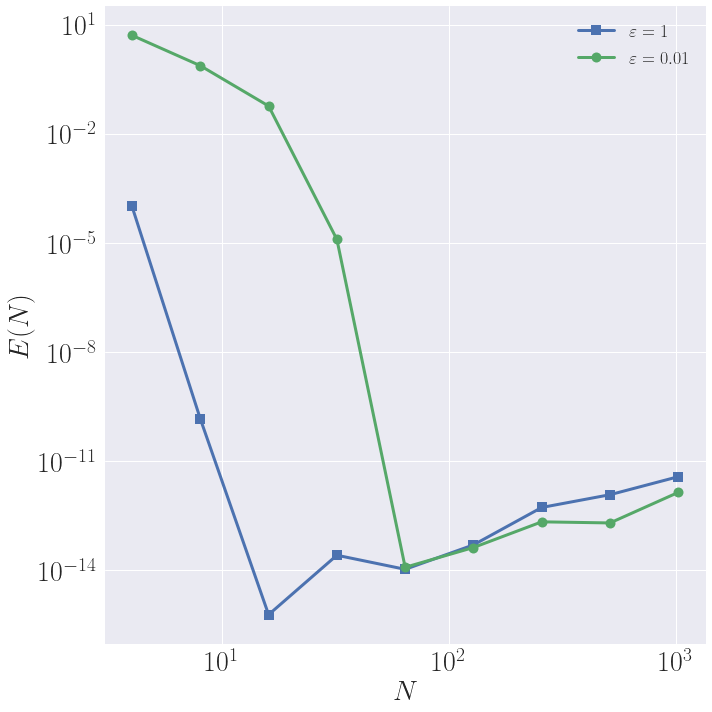

In [84]:
plot_1a()

## Part B

In [85]:
class q1b(object):
    
    def __init__(self, left=-2.0, right=1.0, alpha=0.0, beta=2.0, N=16, N_fine=50):
        
        # unload the variables
        self.left = left
        self.right = right
        self.alpha = alpha
        self.beta = beta
        self.N = N
        self.N_fine = N_fine
        
        # find the transformation that rescales the domain [left, right] to [-1,1]
        self.b, self.m = solve(
            array([[1, self.left],
                   [1, self.right]]), 
            array([-1, 1])
            )
        
        # get the LHS matrix and the grid points
        self.A, self.z, self.x = self.get_A()
        
        # shift the chebyshev grid to be
        # on the correct domain
        
        # get the RHS vector 
        self.F = self.get_rhs()
        
        # compute the solution
        self.U = self.compute_soln()
        
    def get_A(self):
        
        # compute the Chebyshev differentiation matrices and points
        D, z = cheb(self.N)
        
        x = (1./self.m)*(z - self.b)
        
        D *= self.m
        
        # define the matrix A with proper rescalings
        A = dot(D,D) - diag(8*x)
        
        # impose boundary conditions on
        # LHS of the equation
        
        # Left boundary
        A[-1,:] = zeros(self.N+1)
        A[-1,-1] = 1.0
        
        # Right boundary
        A[0,:] = D[0,:] # implement rescaling
        
        return A, z, x
        
    def get_rhs(self):
        
        F = -4*(self.x**2)
        
        # set boundary conditions on the RHS
        
        # left boundary
        F[-1] = self.alpha
        
        # right boundary
        F[0] = self.beta
        
        return F
        
    def compute_soln(self):
        return solve(self.A,self.F)
        
    def get_soln_plot(self, save=False):        
        
        fig, ax = subplots(1,1,figsize=(10,10))
        
        xx = linspace(self.left, self.right, self.N_fine+1)
        
        uu = polyval(polyfit(self.x, self.U, self.x.size), xx)

        ax.plot(xx, uu, "ko-", lw=3.0, label="Computed soln")
        
        ax.legend(loc=0, prop={"size": 18})
        ax.tick_params(labelsize=18)
        ax.set_ylabel(r"$U(x)$", fontsize=28)
        ax.set_xlabel(r"$x$", fontsize=28)
        
        fig.tight_layout()
        
        if save: fig.savefig("q1b_soln_figure.pdf")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


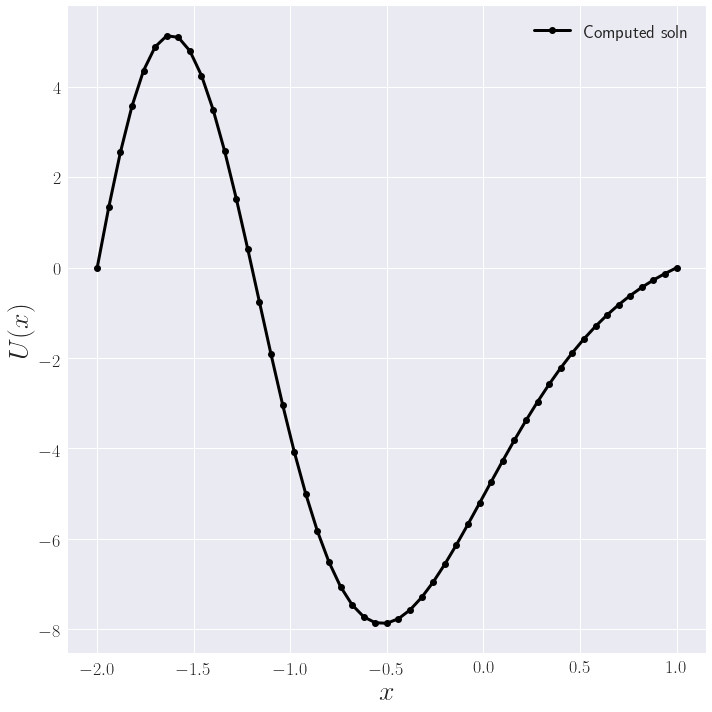

In [86]:
sample_q1b = q1b(alpha=0.0, beta=2.0)
sample_q1b.get_soln_plot(save=True)

In [87]:
def q1b_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        Nvals = zeros(n)
        pt_error_array_norm = zeros(n)
        error_array_infnorm = zeros(n)

        # set the number of initial number of internal points
        N_coarse = (2**2)
        # solve on initial mesh
        soln_coarse = q1b(N=N_coarse)

        print(f"N    err       order")
        
        for i in range(n):

            # define the finer grids
            N_fine = 2*N_coarse

            # construct the meshes and solve 
            soln_fine = q1b(N=N_fine)

            # compute the errors using the infinity-norm
            error_array_infnorm[i] = norm((soln_coarse.U-soln_fine.U[::2]).flatten(), ord=inf)

            # record the number of points
            Nvals[i] = N_coarse
            
            if (i > 0):
                print(
                    f"{N_coarse:<5d}"
                    + f"{error_array_infnorm[i]:<10.2e}"
                    + f"{-log2((error_array_infnorm[i]/error_array_infnorm[i-1]).__abs__()):<10.5f}"
                    )
            else:
                print(
                    f"{N_coarse:<5d}"
                    + f"{error_array_infnorm[i]:<10.2e}"
                    )
                
            # set the current fine grid as the coarse grid for next iteration
            N_coarse = N_fine 
            soln_coarse = soln_fine

        return Nvals, error_array_infnorm

In [88]:
def plot_1b():
    
    Nvals, error_array_infnorm = q1b_compute_grid_error_scaling()

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array_infnorm, "s-", ms=10.0, lw=3.0)
    
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q1b_err_figure.pdf")

N    err       order
4    8.77e+00  
8    5.22e-02  7.39325   
16   6.56e-06  12.95771  
32   7.30e-13  23.09872  
64   1.46e-12  -1.00000  
128  1.28e-11  -3.13029  
256  9.13e-11  -2.83675  
512  1.65e-10  -0.84924  
1024 3.02e-10  -0.87792  


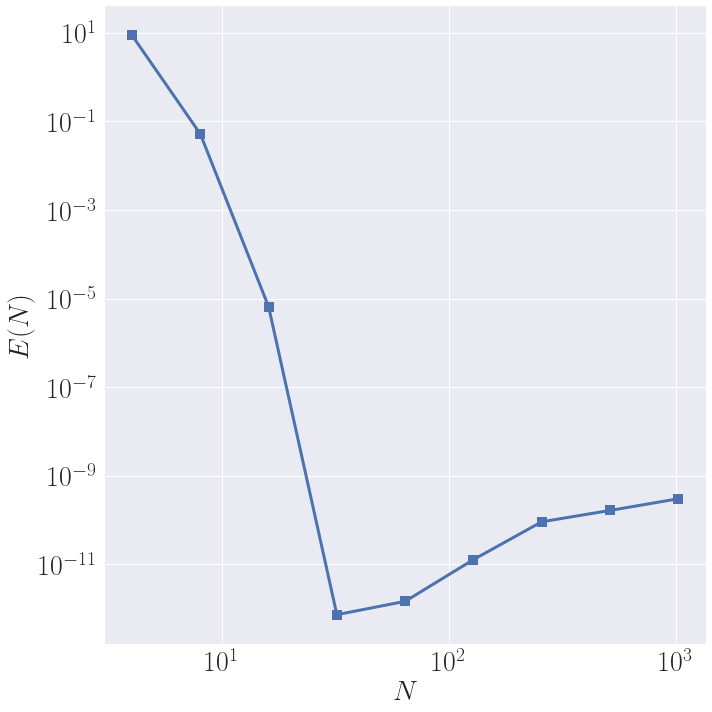

In [89]:
plot_1b()